In [5]:
import time
import toml
import numpy as np
import matplotlib.pyplot as plt
from ref_traj2 import generate_trajectory as traj
%matplotlib notebook

There are a lot of configuration parameters. It is a good idea to separate it from the main code. At some point you will be doing parameter tuning. 

We will use toml format to store parameters. Open config.toml and go over the description of the different parameters we may use here

Read the config parameters, default output is a dictionary. You have to then store them as local variables. 
You have 2 options for this
1. update locals() directly - a little bit dangerous
2. You can use itemgetter

In [6]:
config_params = toml.load('config.toml')['params']
locals().update(config_params)
print(config_params)
print(dt)


{'dt': 0.1, 'V_MAX': 1.2, 'W_MAX': 1.0, 'K_MAX': 0.5, 'MIN_DIST': 1.0, 'ACC_MAX': 0.5, 'W_DOT_MAX': 3.0, 'LATERAL_ACC_MAX': 1.5, 'goal_threshold': 0.05, 'pred_horizon': 10, 'w_cte': 1.0, 'w_speed': 1.0}
0.1


There are 3 functions we need to write for DWA

1. Simulate unicyle - we will slightly modify it to simulate $N$ steps 

2. Command Window - Entire set of acceptable $(v, \omega)$ in that time instant given current $(v, \omega)$$

3. track - get $(v, \omega )$ for path with the lowest cost

In the first iteration, let us not integrate collision checking. Let us integrate these pieces, make sure DWA works for a few paths!

In [7]:
def circle_collision_check(grid, local_traj):
    xmax, ymax = grid.shape
    all_x = np.arange(xmax)
    all_y = np.arange(ymax)
    X, Y = np.meshgrid(all_x, all_y)
    for xl, yl, tl in local_traj:
      rot = np.array([[np.sin(tl), -np.cos(tl)],[np.cos(tl), np.sin(tl)]])
      for xc, yc, rc in circles:
        xc_rot, yc_rot = rot @ np.array([xc, yc]) + np.array([xl, yl])
        xc_pix, yc_pix = int(xc_rot/grid_res), int(yc_rot/ grid_res)
        rc_pix = (rc/ grid_res)
        inside_circle = ((X-xc_pix)**2 +(Y-yc_pix)**2 - rc_pix**2 < 0)
        occupied_pt = grid[X, Y] == 1
        if np.sum(np.multiply( inside_circle, occupied_pt)):
          return True
    return False

In [64]:
def simulate_unicycle(pose, v,w, N=1, dt=0.1):
    all_poses = []
    for _ in range(N):
        x = pose[0] + v*np.cos(pose[2])*dt
        y = pose[1] + v*np.sin(pose[2])*dt
        theta = pose[2] + w*dt
        all_poses.append([x,y,theta])

    
    return np.array(all_poses)

def command_window(v, w, dt=0.1):
    """Returns acceptable v,w commands given current v,w"""
    # velocity can be (0, V_MAX)
    # ACC_MAX = max linear acceleration
    v_max = min((v + ACC_MAX*dt),V_MAX)
    v_min = max((v - ACC_MAX*dt),0)
    # omega can be (-W_MAX, W_MAX)
    #W_DOT_MAX = max angular acceleration
    
    w_max = min((w + W_DOT_MAX*dt),W_MAX)
    w_min = max((w - W_DOT_MAX*dt),-W_MAX)
    
    #generate quantized range for v and omega
    vs = np.linspace(v_min, v_max, num=11) # num depends on our computation time
    ws = np.linspace(w_min, w_max, num=21)
    
    #cartesian product of [vs] and [ws]
    #remember there are 0 velocity entries which have to be discarded eventually
    commands = np.transpose([np.tile(vs, len(ws)), np.repeat(ws, len(vs))])
    epsilon = 1e-6
    #calculate kappa for the set of commands
    kappa = commands[:,1]/(commands[:,0] + epsilon)
    #print("commands = ", commands[(kappa < K_MAX) & (commands[:, 0] != 0)])
    #returning only commands < max curvature 
    return commands[(kappa < K_MAX) & (commands[:, 0] != 0)]

def track(ref_path, pose, v, w, dt=0.1):
    commands = command_window(v, w)
    #initialize path cost
    best_cost, best_command = np.inf, None
    for i, [v, w] in enumerate(commands):
        local_path = simulate_unicycle(pose,v,w,pred_horizon) #Number of steps = prediction horizon
        
        #if circle_collision_check(grid, local_path): #ignore colliding paths
        #    continue
        # if circle_collision_check(grid, local_path): #ignore colliding paths
        #     print("collision!")
        #     continue
        #calculate cross-track error
        #can use a simplistic definition of 
        #how close is the last pose in local path from the ref path
       
        ref_x = ref_path[-1][0]
        ref_y = ref_path[-1][1]
        xc,yc,t = local_path[-1]
        #print((ref_x,ref_y))
        cte = np.sqrt((ref_x-xc)**2+ (ref_y-yc)**2)
        #print("cte = ", cte)
        #other cost functions are possible
        #can modify collision checker to give distance to closest obstacle
        cost = w_cte*cte + w_speed*(V_MAX - v)**2
        #print("cost = ", cost)
        #check if there is a better candidate
        if cost < best_cost:
            best_cost, best_command = cost, (v,w)

    if best_command != None:
        return best_command
    else:
        return [0, 0]
start_pose = np.array([[0, 0, np.pi/2]])                #,[0, 0, np.pi/2]])
route = [("straight", 5)] #                      ,("turn", -90),("straight", 6),("turn", 90)]
ref_path = traj(route, start_pose[0]).T


pose = start_pose
logs = []
path_index = 0
v, w = 0.0, 1
while path_index < len(ref_path)-1:
    t0 = time.time()
    local_ref_path = ref_path[path_index:path_index+pred_horizon]
    # update path_index using current pose and local_ref_path
    x,y= pose[0][0],pose[0][1]
    ref_x,ref_y  = ref_path[-1][0],ref_path[-1][1]
    #print(pose)
    #print(local_ref_path[-1])
    if np.sqrt((ref_x-x)**2+(ref_y-y)**2)>=goal_threshold:
        path_index += 1
    # get next command
    v, w = track(local_ref_path,pose[0],v,w)
    
    #simulate vehicle for 1 step
    # remember the function now returns a trajectory, not a single pose
    pose = simulate_unicycle(pose[0],v,w,pred_horizon,dt)
    
    #update logs
    logs.append([*pose, v, w])
    t1 = time.time() #simplest way to time-profile your code
    print(f"idx:{path_index}, v:{v:0.3f}, w:{w:0.3f}, time:{(t1-t0) * 1000:0.1f}ms")    
    poses = np.array(logs)[:,:3]
plt.figure()
plt.axes().set_aspect('equal', 'datalim')
plt.plot(ref_path[:,0], ref_path[:,1], '.', c='g')
#plt.plot(poses[:,0], poses[:,1], c='r')    

idx:1, v:0.000, w:0.000, time:0.3ms
idx:2, v:0.050, w:-0.300, time:8.0ms
idx:3, v:0.100, w:-0.600, time:15.0ms
idx:4, v:0.150, w:-0.900, time:17.6ms
idx:5, v:0.200, w:-1.000, time:17.1ms
idx:6, v:0.250, w:-1.000, time:17.6ms
idx:7, v:0.300, w:-1.000, time:17.9ms
idx:8, v:0.350, w:-1.000, time:17.0ms
idx:9, v:0.400, w:-1.000, time:17.5ms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


<IPython.core.display.Javascript object>

In [ ]:
start_pose = np.array([0, 0, np.pi/2])
route = [("straight", 5),("turn", -90),("straight", 6),("turn", 90)]
ref_path = traj(route, start_pose).T

pose = start_pose
logs = []
path_index = 0
v, w = 0.0, 0.0
while path_index < len(ref_path)-1:
    t0 = time.time()
    local_ref_path = ref_path[path_index:path_index+pred_horizon]
    # update path_index using current pose and local_ref_path
    path_index = path_index + 1
    # get next command
    v, w = track(local_ref_path,pose,v,w)
    
    #simulate vehicle for 1 step
    # remember the function now returns a trajectory, not a single pose
    pose = simulate_unicycle(pose,v,w,pred_horizon,dt)
    
    #update logs
    logs.append([*pose, v, w])
    t1 = time.time() #simplest way to time-profile your code
    print(f"idx:{path_index}, v:{v:0.3f}, w:{w:0.3f}, time:{(t1-t0) * 1000:0.1f}ms")


idx:0, v:0.050, w:0.000, time:2.2ms
idx:0, v:0.100, w:-0.030, time:3.8ms
idx:0, v:0.150, w:-0.060, time:8.3ms
idx:0, v:0.200, w:-0.090, time:16.9ms
idx:0, v:0.250, w:0.030, time:14.2ms
idx:0, v:0.300, w:0.030, time:11.7ms
idx:0, v:0.350, w:0.030, time:21.2ms
idx:0, v:0.400, w:0.030, time:23.5ms
idx:0, v:0.450, w:0.030, time:22.0ms
idx:0, v:0.500, w:0.030, time:21.2ms
idx:0, v:0.550, w:0.030, time:33.6ms
idx:1, v:0.600, w:0.000, time:34.7ms
idx:1, v:0.650, w:0.000, time:51.7ms
idx:1, v:0.700, w:0.000, time:26.8ms
idx:1, v:0.700, w:0.000, time:18.7ms
idx:1, v:0.700, w:0.000, time:19.4ms
idx:1, v:0.750, w:0.000, time:19.5ms
idx:1, v:0.800, w:0.000, time:19.6ms
idx:1, v:0.850, w:0.000, time:24.6ms
idx:2, v:0.800, w:0.000, time:26.0ms
idx:2, v:0.750, w:0.000, time:22.0ms
idx:2, v:0.700, w:0.000, time:39.4ms
idx:2, v:0.700, w:0.000, time:24.8ms
idx:2, v:0.750, w:0.000, time:20.1ms
idx:2, v:0.800, w:0.000, time:19.5ms
idx:2, v:0.850, w:0.000, time:26.7ms
idx:3, v:0.800, w:0.000, time:20.5ms
i

idx:30, v:0.810, w:0.090, time:37.2ms
idx:31, v:0.760, w:0.090, time:41.8ms
idx:31, v:0.710, w:0.090, time:44.5ms
idx:31, v:0.700, w:0.090, time:34.7ms
idx:31, v:0.700, w:0.060, time:18.3ms
idx:31, v:0.750, w:0.240, time:19.0ms
idx:31, v:0.800, w:0.240, time:14.4ms
idx:31, v:0.780, w:0.210, time:15.3ms
idx:32, v:0.730, w:0.180, time:15.9ms
idx:32, v:0.700, w:0.180, time:14.9ms
idx:32, v:0.700, w:0.150, time:17.4ms
idx:32, v:0.750, w:0.360, time:18.7ms
idx:32, v:0.800, w:0.330, time:10.3ms
idx:32, v:0.830, w:0.300, time:12.1ms
idx:32, v:0.780, w:0.270, time:13.6ms
idx:33, v:0.730, w:0.240, time:14.0ms
idx:33, v:0.700, w:0.240, time:17.9ms
idx:33, v:0.700, w:0.210, time:16.6ms
idx:33, v:0.750, w:0.360, time:15.7ms
idx:33, v:0.800, w:0.390, time:19.3ms
idx:33, v:0.810, w:0.360, time:12.5ms
idx:34, v:0.760, w:0.330, time:12.1ms
idx:34, v:0.710, w:0.300, time:12.0ms
idx:34, v:0.700, w:0.300, time:16.3ms
idx:34, v:0.700, w:0.270, time:11.4ms
idx:34, v:0.750, w:0.360, time:12.4ms
idx:34, v:0.

<IPython.core.display.Javascript object>


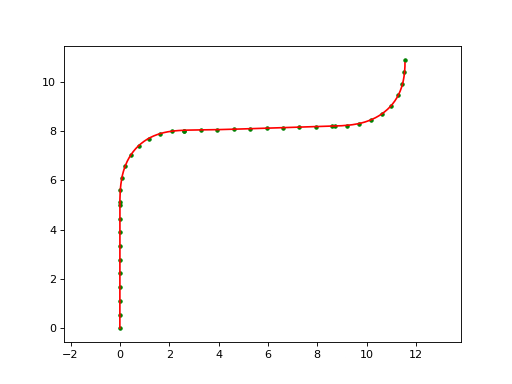

In [ ]:
poses = np.array(logs)[:,:3]
plt.figure()
plt.axes().set_aspect('equal', 'datalim')
plt.plot(ref_path[:,0], ref_path[:,1], '.', c='g')
plt.plot(poses[:,0], poses[:,1], c='r')

Now it should be relatively straight-forward to integrate collision checking in the grid environment the robot is going to navigate

In [29]:
start_pose = np.array([0, 0, np.pi/2])
route = [("straight", 5),("turn", -90),("straight", 6),("turn", 90)]
ref_path = traj(route, start_pose).T

pose = start_pose
logs = []
path_index = 0
v, w = 0.0, 0.0
while path_index < len(ref_path)-1:
    t0 = time.time()
    local_ref_path = ref_path[path_index:path_index+pred_horizon]
    # update path_index using current pose and local_ref_path
    path_index = path_index + 1
    # get next command
    v, w = track(local_ref_path,pose,v,w)
    
    #simulate vehicle for 1 step
    # remember the function now returns a trajectory, not a single pose
    pose = simulate_unicycle(pose,v,w,pred_horizon,dt)
    
    #update logs
    logs.append([*pose, v, w])
    t1 = time.time() #simplest way to time-profile your code
    print(f"idx:{path_index}, v:{v:0.3f}, w:{w:0.3f}, time:{(t1-t0) * 1000:0.1f}ms")

cte =  4.9995
cost =  6.427525
cte =  4.999
cost =  6.4151
cte =  4.9985
cost =  6.402725
cte =  4.998
cost =  6.3904
cte =  4.9975
cost =  6.378125
cte =  4.997
cost =  6.3659
cte =  4.9965
cost =  6.353725000000001
cte =  4.996
cost =  6.341600000000001
cte =  4.9955
cost =  6.329525
cte =  4.995
cost =  6.3175
cte =  4.9995
cost =  6.427525
cte =  4.999
cost =  6.4151
cte =  4.9985
cost =  6.402725
cte =  4.998
cost =  6.3904
cte =  4.9975
cost =  6.378125
cte =  4.997
cost =  6.3659
cte =  4.9965
cost =  6.353725000000001
cte =  4.996
cost =  6.341600000000001
cte =  4.9955
cost =  6.329525
cte =  4.995
cost =  6.3175
cte =  4.9995
cost =  6.427525
cte =  4.999
cost =  6.4151
cte =  4.9985
cost =  6.402725
cte =  4.998
cost =  6.3904
cte =  4.9975
cost =  6.378125
cte =  4.997
cost =  6.3659
cte =  4.9965
cost =  6.353725000000001
cte =  4.996
cost =  6.341600000000001
cte =  4.9955
cost =  6.329525
cte =  4.995
cost =  6.3175
cte =  4.9995
cost =  6.427525
cte =  4.999
cost =  6.4

ValueError: ignored